In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from matplotlib import cm
# %matplotlib inline
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [9]:
def str_coef(c):
    """
    Args:
        c: An double/float number as coefficient
    """
    if c<0:
        return str(c)
    else:
        return '+' + str(c)

def get_equ_str(model):
    """
    Args:
        model: a pipeline with first step as preprossor(PolynomialFeatures), 
            second step as any regression model(LinearRegeression, Ridge etc.)
    """
    # get coeff and polynomial equations
    poly_features = model.get_params(0)['steps'][0][1]
    lng = model.get_params(0)['steps'][1][1]
    poly_terms = poly_features.get_feature_names()
    poly_coef = np.squeeze(lng.coef_)
    equ = [ str_coef(c)+t for t,c in reversed(zip(poly_terms,poly_coef))]
    return ' '.join(equ)

def gen_mesh_2D(x1_low, x1_upper, x2_low, x2_upper, n=200):
    x1_mesh = np.linspace(x1_low,x1_upper,200)
    x2_mesh = np.linspace(x2_low,x2_upper, 200)
    x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh)
    nx1, nx2 = x1_mesh.shape
    x1_vec = np.squeeze(np.asarray(np.reshape(x1_mesh, (nx1*nx2,1))))
    x2_vec = np.squeeze(np.asarray(np.reshape(x2_mesh, (nx1*nx2,1))))
    Xp = np.stack([x1_vec, x2_vec],axis=1)
    return x1_mesh, x2_mesh, Xp

def polynomial_fit_2D(df, y_col_names, x1_col, x2_col2, name_dict, degree, lng=LinearRegression()):
    x1_mesh,x2_mesh,Xp = gen_mesh_2D(df[x1_col].min(),df[x1_col].max(),
                                     df[x2_col].min(),df[x2_col].max())
    model = make_pipeline(PolynomialFeatures(degree), lng)
    
    
    n_row = int(math.ceil(len(y_col_names)/2.0))
    fig = plt.figure(figsize=(10,4*n_row))
    X = df.as_matrix(x_col_names)
    for i,y_col_name in enumerate(y_col_names):
        # train model
        y = df.as_matrix([y_col_name])
        model.fit(X,y)
        
        # print error
        title = x1_col + ', ' + x2_col + ' vs '+ y_col_name
        MSE = mean_squared_error(y, model.predict(X))
        print title + ' RMSE:' + str(math.sqrt(MSE))
        
        # draw fitted surface
        yp = model.predict(Xp)
        yp_mesh = np.reshape(yp, (nx1,nx2))
        ax = fig.add_subplot(n_row,2,i+1, projection='3d')
        ax.scatter(df[x1_col], df[x2_col], df[y_col_name], label="table data")
        ax.set_xlabel(name_dict[x1_col])
        ax.set_ylabel(name_dict[x2_col])
        ax.set_zlabel(name_dict[y_col_name])
        ax.plot_surface(x1_mesh, x2_mesh, yp_mesh, color='r',alpha=0.5)
        leg = ax.legend(loc='upper right')
        leg.get_frame().set_alpha(0.5)
        z_min = df[y_col_name].min() -abs(df[y_col_name].min())
        z_max = df[y_col_name].max() + abs(df[y_col_name].max())
        ax.set_zlim(z_min,z_max)
        ax.view_init(30, 55)
        plt.title(title)
        str_equ = get_equ_str(model)
        print title + ' equation (x0 is ' + x1_col +', x1 is ' + x2_col + ') '
        print str_equ + '\n'

<IPython.core.display.Javascript object>


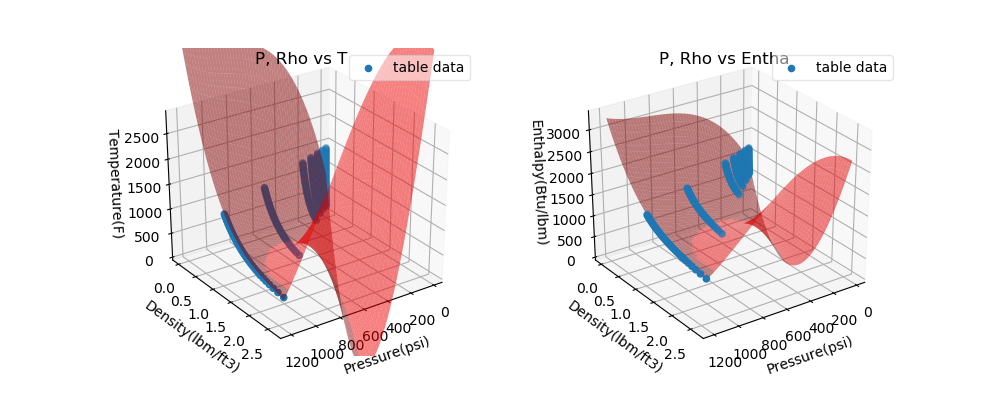

P, Rho vs T RMSE:161.447307276
P, Rho vs T equation (x0 is P, x1 is Rho) 
-246.223480714x1^3 -1.9278152375x0 x1^2 +1.56047345057e-05x0^2 x1 +4.52413091114e-06x0^3 +4043.57822747x1^2 +2.7483618608x0 x1 -0.0117453196769x0^2 -7632.12629281x1 +10.5226919947x0 +0.01

P, Rho vs Entha RMSE:81.5510835258
P, Rho vs Entha equation (x0 is P, x1 is Rho) 
-146.069094965x1^3 -0.906492902154x0 x1^2 -3.77977333453e-05x0^2 x1 +2.27160170115e-06x0^3 +2074.64340451x1^2 +1.30700993082x0 x1 -0.00585872950293x0^2 -3952.45350374x1 +5.38501189811x0 +0.01



In [287]:
df = pd.read_table('./supersteam_table_fit.txt', sep='\s+', header=0, index_col=False)
name_dict = {'Entha': 'Enthalpy(Btu/lbm)',
             'P': 'Pressure(psi)',
             'Rho': 'Density(lbm/ft3)',
             'T': 'Temperature(F)'}
polynomial_fit_2D(df, ['T', 'Entha'], 'P', 'Rho', name_dict, 3)

In [12]:
def polynomial_fit_1D(df, y_col_names, x_col, name_dict, degree, lng=LinearRegression()):
    fig = plt.figure()
    for y_col in y_col_names:
        model = make_pipeline(PolynomialFeatures(degree), lng)
        X = df.as_matrix([x_col])
        y = df.as_matrix([y_col])
        model.fit(X,y)
        Xp = np.reshape(np.linspace(df[x_col].min(), df[x_col].max(), 1000), (1000,1))
        yp = model.predict(Xp)

        ax = fig.add_subplot(111)
        ax.scatter(df[x_col], df[y_col], alpha=0.5)
        ax.plot(Xp, yp, label=(y_col+' fit'))
        equ = get_equ_str(model)
        print 'Equation for ' + y_col + '(x0 is P):'
        print equ + '\n'
        ax.set_ylabel(name_dict[y_col])
    plt.title('PV envolope (P_crit=3185psi(guage), Rho_crit=20.102 lbm/ft3) Degree=' + str(degree))
    ax.set_xlabel(name_dict[x_col])
    ax.legend()
    ax.grid()

<IPython.core.display.Javascript object>


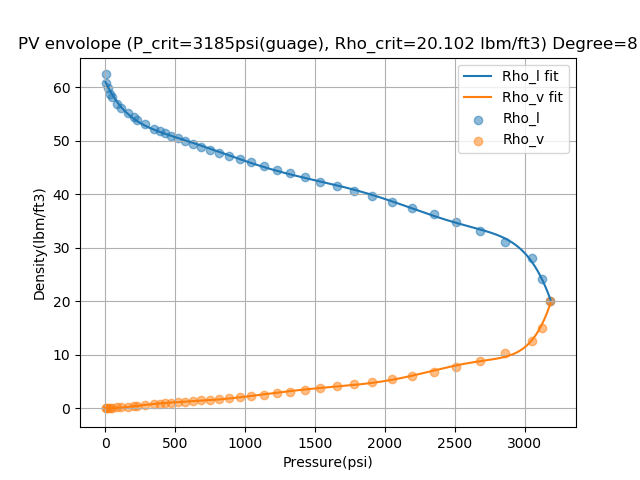

Equation for Rho_l(x0 is P):
+7.45927730434e-26x0^8 -2.52393404977e-21x0^7 +2.20092550479e-17x0^6 -8.77105176223e-14x0^5 +1.86206369217e-10x0^4 -2.19442511525e-07x0^3 +0.000141628166362x0^2 -0.0550091313261x0 +0.01

Equation for Rho_v(x0 is P):
+8.80702064218e-25x0^8 -1.01029358705e-20x0^7 +4.6787405794e-17x0^6 -1.11987412717e-13x0^5 +1.47252757514e-10x0^4 -1.04054383051e-07x0^3 +3.58568547261e-05x0^2 -0.00255144208707x0 +0.01



In [23]:
df2 = pd.read_table('./saturated_table_fit.txt', sep='\s+', header=0)
name_dict2 = {'P': 'Pressure(psi)','Rho_l': 'Density(lbm/ft3)','Rho_v': 'Density(lbm/ft3)'}
polynomial_fit_1D(df2, ['Rho_l', 'Rho_v'], 'P', name_dict2, 8, Ridge())

<IPython.core.display.Javascript object>


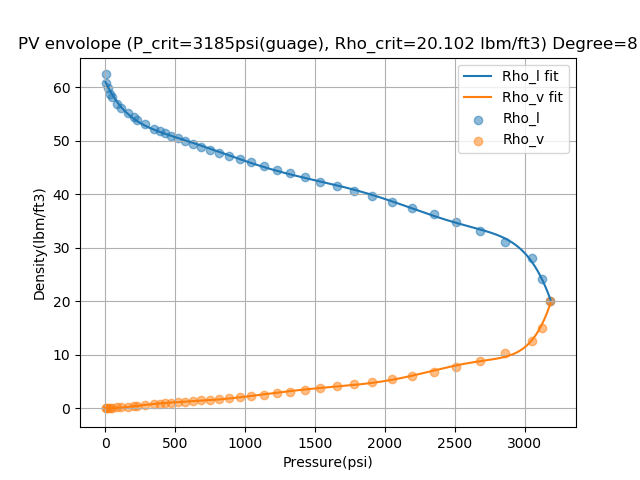

Equation for Rho_l(x0 is P):
+7.45927730434e-26x0^8 -2.52393404977e-21x0^7 +2.20092550479e-17x0^6 -8.77105176223e-14x0^5 +1.86206369217e-10x0^4 -2.19442511525e-07x0^3 +0.000141628166362x0^2 -0.0550091313261x0 +0.01

Equation for Rho_v(x0 is P):
+8.80702064218e-25x0^8 -1.01029358705e-20x0^7 +4.6787405794e-17x0^6 -1.11987412717e-13x0^5 +1.47252757514e-10x0^4 -1.04054383051e-07x0^3 +3.58568547261e-05x0^2 -0.00255144208707x0 +0.01


In [230]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.scatter(df2[x_col], df2[y1_col], alpha=0.5)
ax.scatter(df2[x_col], df2[y2_col], alpha=0.5)
ax.plot(Xp, yp1, label=(y1_col+' fit'))
ax.plot(Xp, yp2, label=(y2_col+' fit'))
ax.set_xlabel('Pressure(psi)')
ax.set_ylabel('Density(lbm/ft3)')
ax.legend()
ax.grid()
plt.title('PV envolope (P_crit=3185psi(guage), Rho_crit=20.102 lbm/ft3) Degree=' + str(degree2))
equ1 = get_equ_str(model2_1)
equ2 = get_equ_str(model2_2)

print 'Equation for ' + y1_col + '(x0 is P):'
print equ1 + '\n'
print 'Equation for ' + y2_col + '(x0 is P):'
print equ2
